In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import emoji
import seaborn as sns
import nltk

C:\Users\Hp\AppData\Roaming\Python\Python310\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
def process_chat(file_path):
    nltk.download('vader_lexicon')

    def clean_text(text):
        text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(,)|\\)|[\\]]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
        text = re.sub(r'<Media omitted>', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word.lower() not in stop_words]
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
        cleaned_text = ' '.join(tokens)
        return cleaned_text

    def analyze_sentiment(cleaned_message):
        sid = SentimentIntensityAnalyzer()
        return sid.polarity_scores(cleaned_message)['compound']

    file = open(file_path, 'r', encoding='utf-8')
    read = file.read()

    pattern = '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s*[ap]m\s-\s'
    messages = re.split(pattern, read)[1:]
    dates = re.findall(pattern, read)

    df = pd.DataFrame({'user_message': messages, 'message_date': dates})
    df['user'], df['message'] = zip(*[(entry[1], " ".join(entry[2:])) if entry[1:] else ('group_notification', entry[0]) for entry in [re.split('([\w\W]+?):\s', message) for message in df['user_message']]])

    df['date'] = [x.split(',')[0] for x in df['message_date']]
    df['time'] = [x.split(',')[1] for x in df['message_date']]
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
    df['time'] = pd.to_datetime(df['time'], format=' %H:%M %p - ')

    df = df.drop(columns='message_date')

    df['hour'] = df['time'].dt.hour
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month_name()
    df['day'] = df['date'].dt.day
    df['minute'] = df['time'].dt.minute

    df['cleaned_message'] = df['message'].apply(clean_text)
    df['sentiment_score'] = df['cleaned_message'].apply(analyze_sentiment)
    df['sentiment_category'] = df['sentiment_score'].apply(lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral'))

    return df


file_path = 'WhatsApp Chat with Maeen 😸 (3).txt'
df = process_chat(file_path)



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
total_messages = df.shape[0]
print('Total number of messages =', total_messages)

Total number of messages = 4989


In [4]:
total_messages_df = pd.DataFrame({'Total_Messages': [total_messages]})

In [5]:
# Save the DataFrame to a CSV file
total_messages_df.to_csv('E:/datasets/DATA/total_messages.csv', index=False)

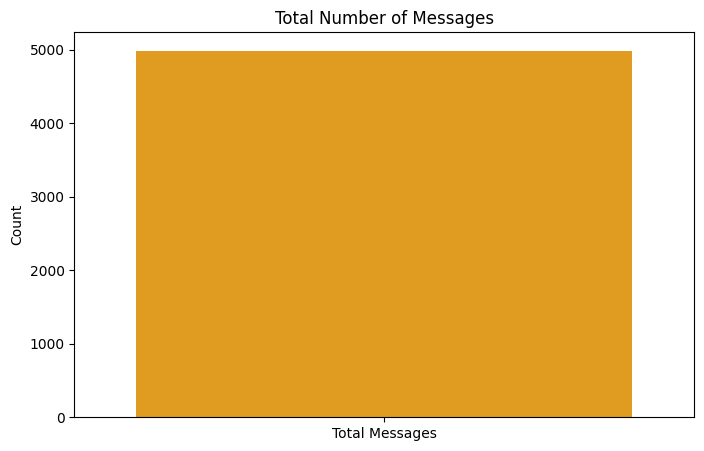

In [6]:
plt.figure(figsize=(8, 5))
sns.barplot(x=['Total Messages'], y=[total_messages], color='orange')
plt.title('Total Number of Messages')
plt.ylabel('Count')
plt.show()

In [7]:
sentiment = df['sentiment_category'].value_counts()

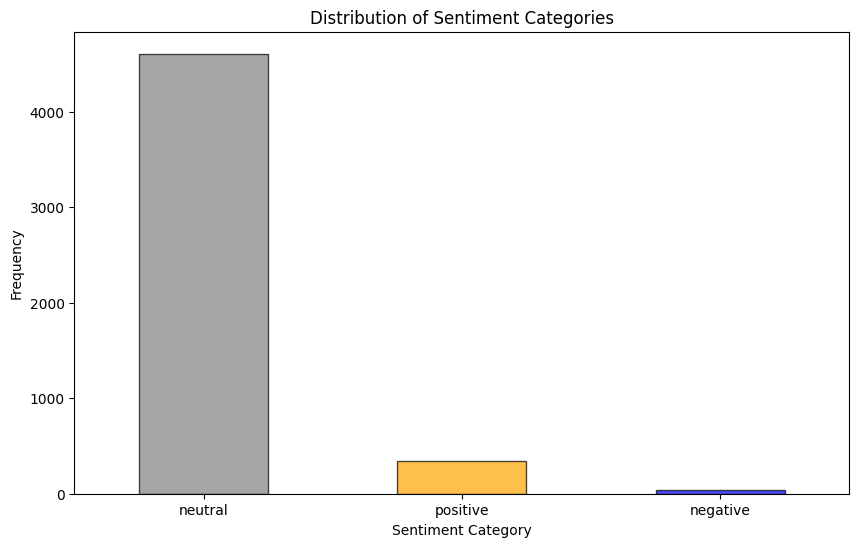

In [8]:
plt.figure(figsize=(10, 6))
df['sentiment_category'].value_counts().plot(kind='bar', color=['grey', 'orange', 'blue'], edgecolor='black', alpha=0.7)
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [9]:
sentiment_by_date = df.groupby(['month', 'sentiment_category']).size().unstack(fill_value=0)

In [10]:
print(sentiment_by_date)

sentiment_category  negative  neutral  positive
month                                          
April                      3      448        32
August                     1      313        17
December                   0      281        16
February                   1      560        63
January                    9      408        38
July                       3      345        15
June                       1      448        14
March                      2      288        11
May                       10      496        24
November                   2      417        49
October                    3      384        54
September                  0      221        12


In [11]:
user_counts = df['user'].value_counts()

In [12]:
user_counts

user
User6                 1184
User5                  803
User2                  602
Uz                     509
User3                  399
Uzair                  333
User10                 273
Najam                  260
User4                  206
User7                  154
User1                  106
User9                   68
Ehtsham                 51
group_notification      41
Name: count, dtype: int64

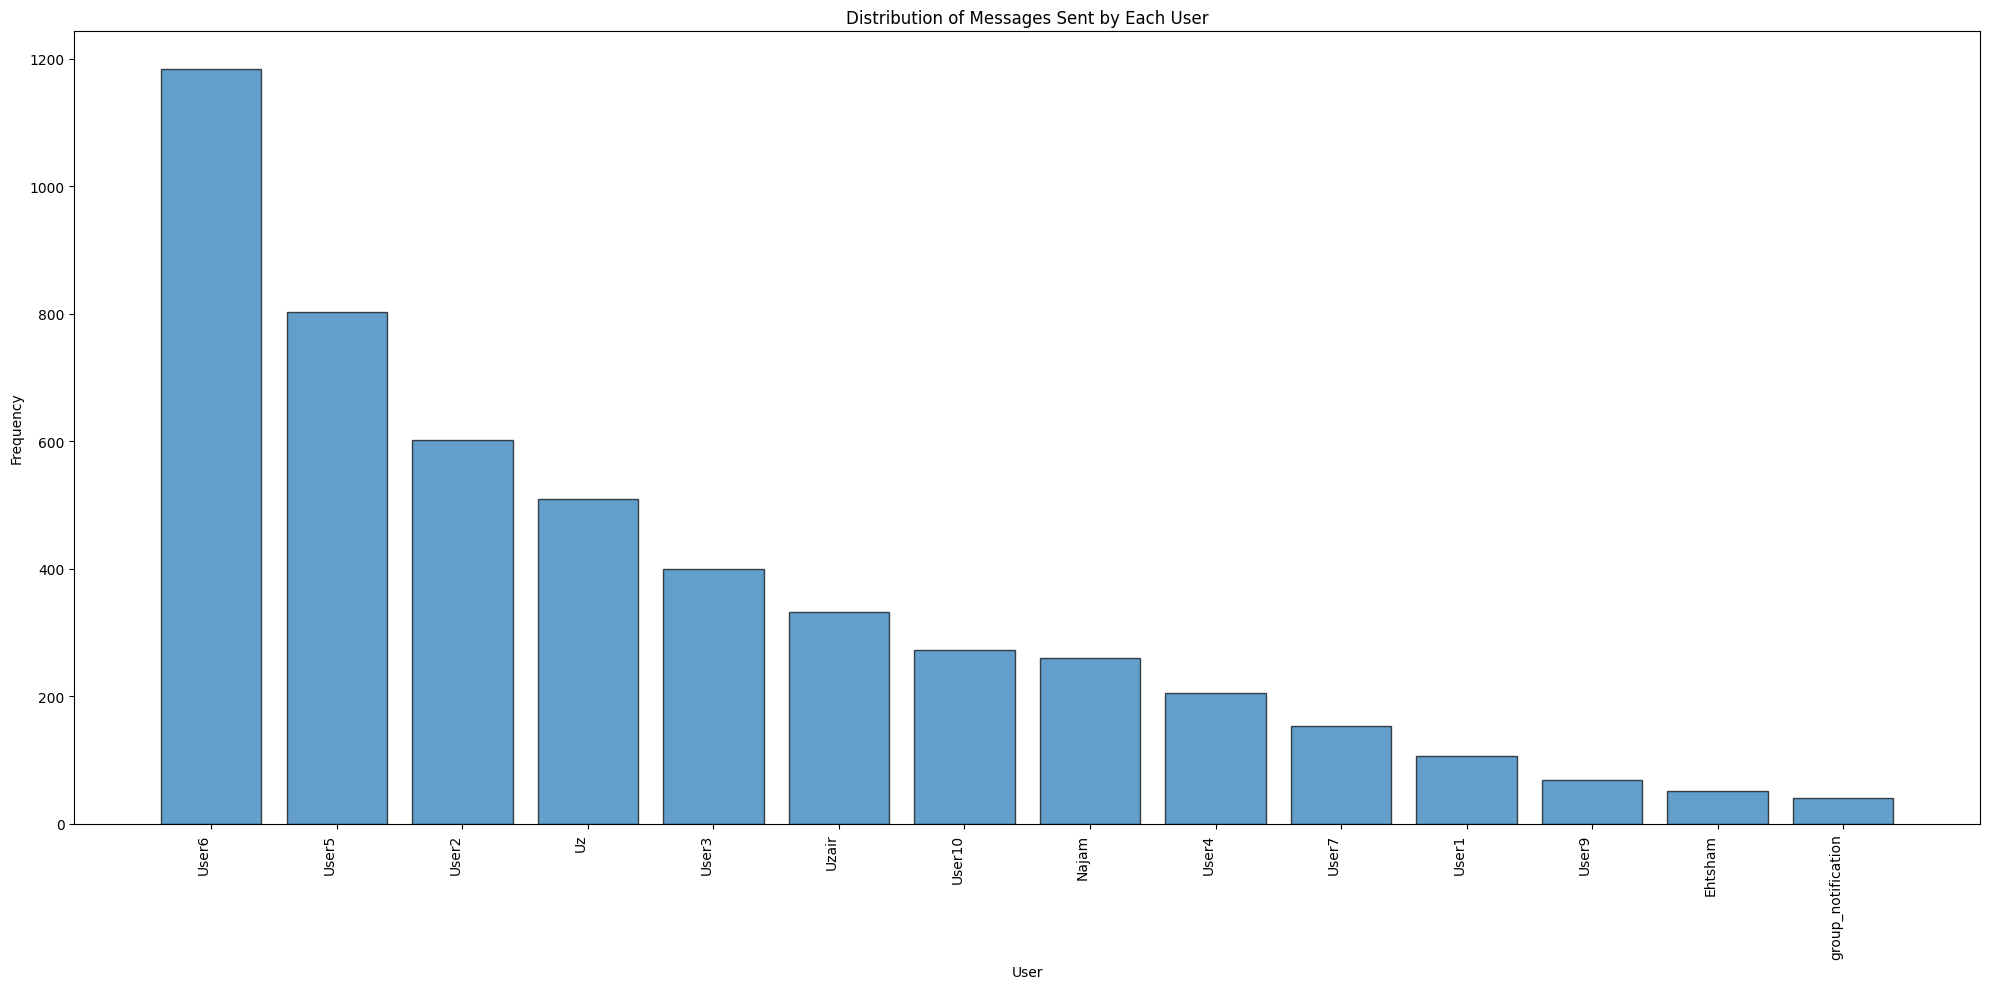

In [13]:
user_counts = df['user'].value_counts()

plt.figure(figsize=(20, 10))
plt.bar(user_counts.index, user_counts, edgecolor='black', alpha=0.7)
plt.title('Distribution of Messages Sent by Each User')
plt.xlabel('User')
plt.ylabel('Frequency')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [14]:
top_users = df['user'].value_counts().head()

In [15]:
top_users

user
User6    1184
User5     803
User2     602
Uz        509
User3     399
Name: count, dtype: int64

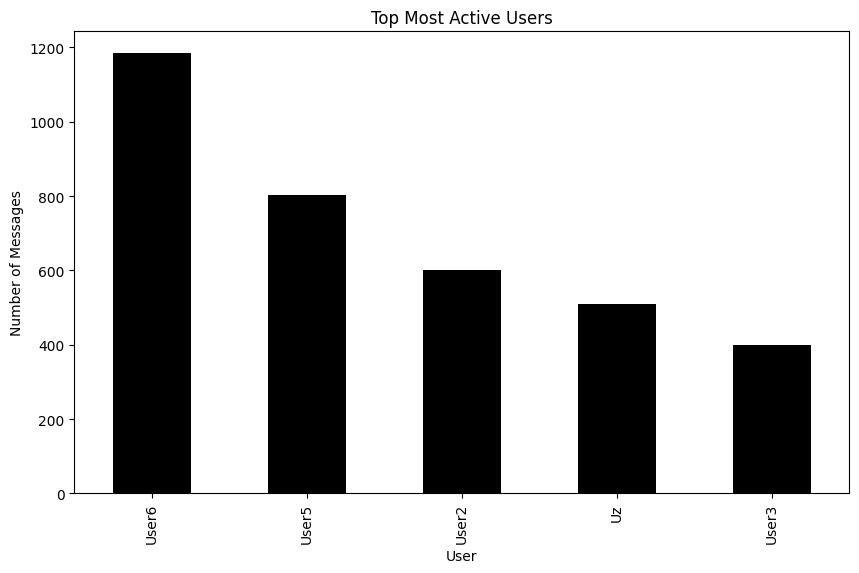

In [17]:
top_users = df['user'].value_counts().head(5)
plt.figure(figsize=(10, 6))
top_users.plot(kind='bar', color='black')
plt.title('Top Most Active Users')
plt.xlabel('User')
plt.ylabel('Number of Messages')
plt.show()

In [19]:
df['day_of_week'] = df['date'].dt.day_name()
daily_message_counts = df.groupby('day_of_week')['message'].count()

In [20]:
daily_message_counts

day_of_week
Friday       619
Monday       665
Saturday     889
Sunday       856
Thursday     725
Tuesday      592
Wednesday    643
Name: message, dtype: int64

In [21]:
df_daily_counts = pd.DataFrame({'Day_of_Week': daily_message_counts.index, 'Message_Count': daily_message_counts.values})

# Specify the file path where you want to save the CSV file
csv_file_path = "E:/datasets/DATA/daily_message_counts.csv"

# Save the DataFrame to a CSV file
df_daily_counts.to_csv(csv_file_path, index=False)

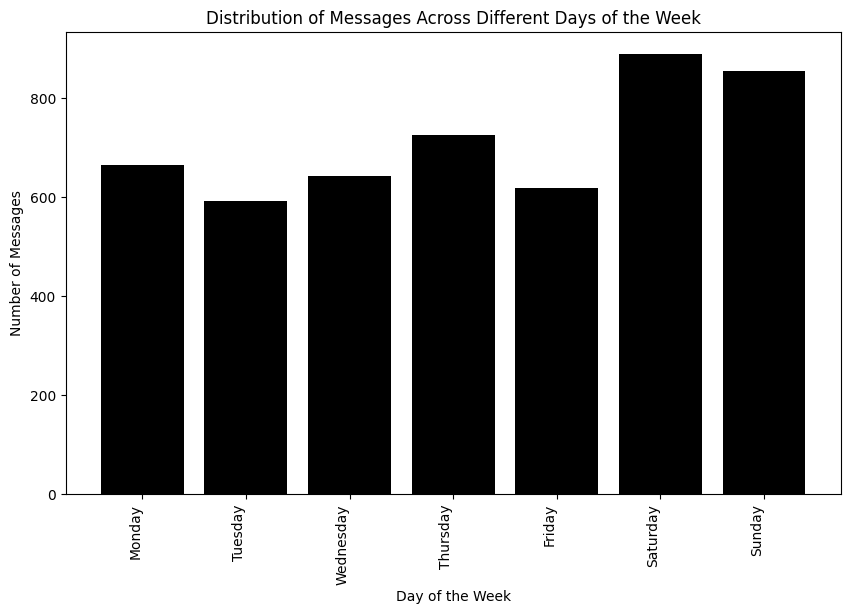

In [22]:
df['day_of_week'] = df['date'].dt.day_name()
daily_message_counts = df.groupby('day_of_week')['message'].count()
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_message_counts = daily_message_counts.reindex(days_order)
plt.figure(figsize=(10, 6))
plt.bar(daily_message_counts.index, daily_message_counts, color='black')
plt.title('Distribution of Messages Across Different Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Messages')
plt.xticks(rotation=90, ha='right')
plt.show()

In [23]:
all_messages = ' '.join(df['cleaned_message'])

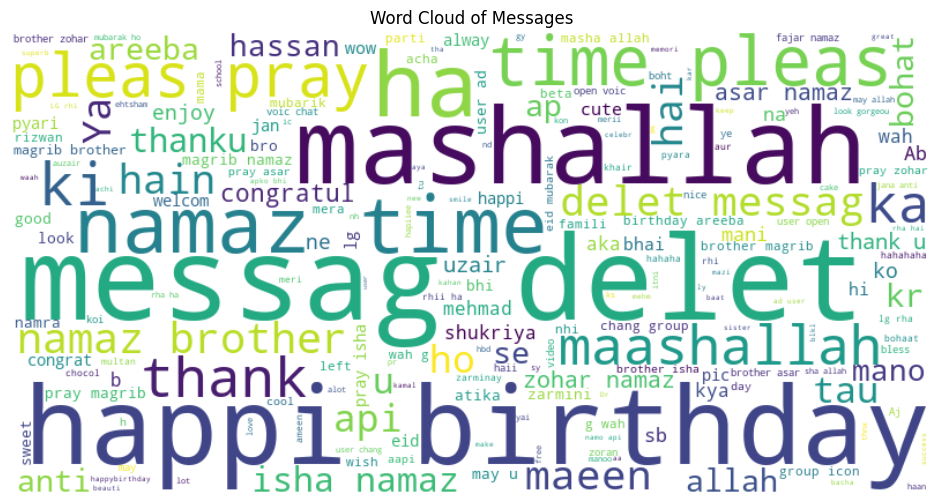

In [24]:
all_messages = ' '.join(df['cleaned_message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_messages)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Messages')
plt.show()

In [26]:
hourly_message_counts = df.groupby('hour')['message'].count()

In [27]:
hourly_message_counts

hour
1     301
2     309
3     165
4     325
5     403
6     419
7     557
8     420
9     680
10    546
11    499
12    365
Name: message, dtype: int64

In [29]:
df_hourly_counts = pd.DataFrame({'Hour': hourly_message_counts.index, 'Message_Count': hourly_message_counts.values})

# Specify the file path where you want to save the CSV file
csv_file_path = "E:/datasets/DATA/hourly_message_counts.csv"

# Save the DataFrame to a CSV file
df_hourly_counts.to_csv(csv_file_path, index=False)

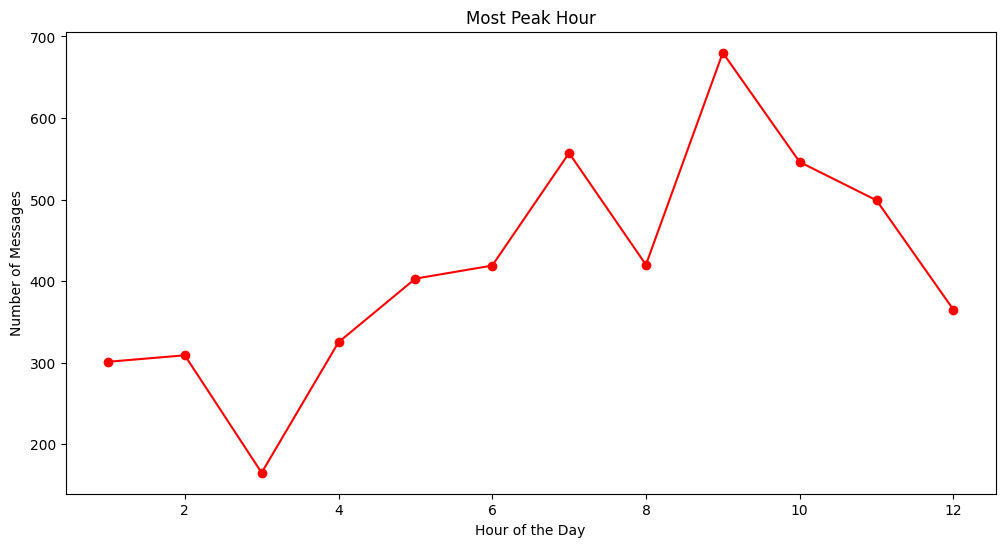

In [30]:
hourly_message_counts = df.groupby('hour')['message'].count()

plt.figure(figsize=(12, 6))
plt.plot(hourly_message_counts.index, hourly_message_counts, marker='o', linestyle='-', color='r')
plt.title('Most Peak Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.show()

In [31]:
daily_activity = df.groupby('date')['message'].count()

In [32]:
daily_activity

date
2018-03-14     2
2018-11-03     9
2018-11-07    13
2018-11-08     8
2018-11-09     5
              ..
2024-03-03     2
2024-03-11     3
2024-03-15     2
2024-03-16     4
2024-03-17     3
Name: message, Length: 752, dtype: int64

In [33]:
df_daily_activity = pd.DataFrame({'Date': daily_activity.index, 'Message_Count': daily_activity.values})

# Specify the file path where you want to save the CSV file
csv_file_path = "E:/datasets/DATA/daily_activity_counts.csv"

# Save the DataFrame to a CSV file
df_daily_activity.to_csv(csv_file_path, index=False)

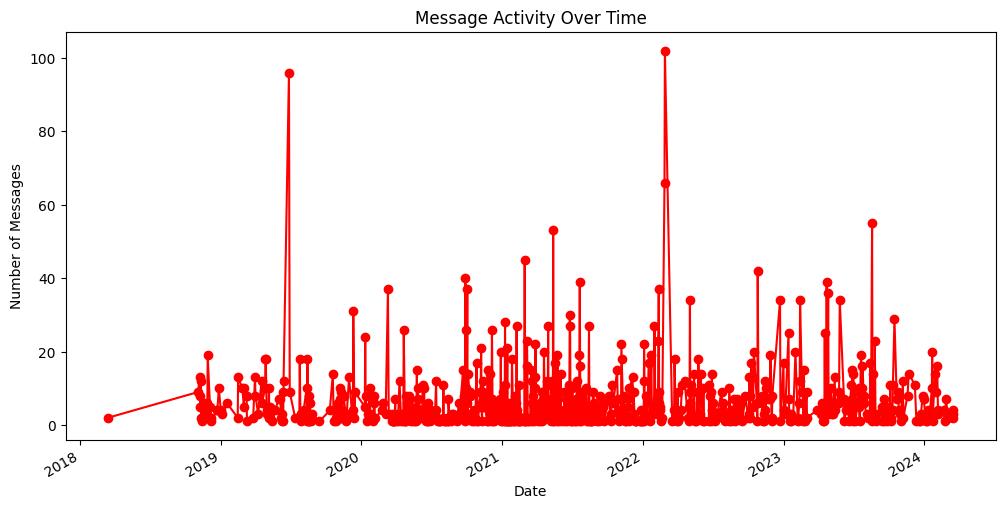

In [34]:
daily_activity = df.groupby('date')['message'].count()
plt.figure(figsize=(12, 6))
daily_activity.plot(marker='o', linestyle='-', color='r')
plt.title('Message Activity Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.show()

In [35]:
monthly_activity = df.groupby('month')['message'].count()

In [36]:
monthly_activity.sort_values(ascending=False)

month
February     624
May          530
April        483
November     468
June         463
January      455
October      441
July         363
August       331
March        301
December     297
September    233
Name: message, dtype: int64

In [37]:
df_monthly_activity = pd.DataFrame({'Month': monthly_activity.index, 'Message_Count': monthly_activity.values})

# Specify the file path where you want to save the CSV file
csv_file_path = "E:/datasets/DATA/monthly_activity_counts.csv"

# Save the DataFrame to a CSV file
df_monthly_activity.to_csv(csv_file_path, index=False)

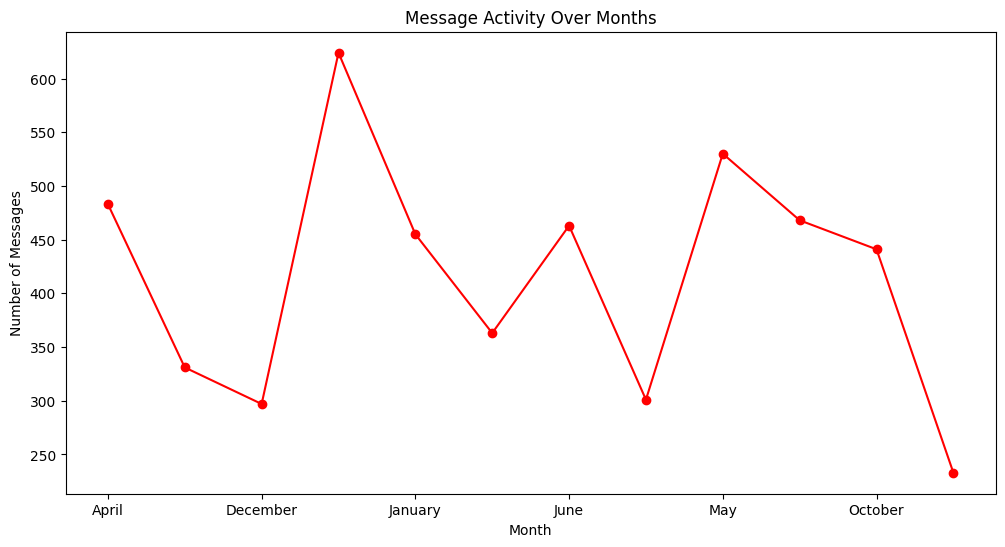

In [38]:
monthly_activity = df.groupby('month')['message'].count()
plt.figure(figsize=(12, 6))
monthly_activity.plot(marker='o', linestyle='-', color='r')
plt.title('Message Activity Over Months')
plt.xlabel('Month')
plt.ylabel('Number of Messages')
plt.show()